<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/05_pytorch_going_modular_exercise_template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. PyTorch Going Modular Exercises

Solved by: Davi Moreno

Welcome to the 05. PyTorch Going Modular exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ijgFhMK3pp4).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/05_pytorch_going_modular_exercise_solutions.ipynb).

## 1. Turn the code to get the data (from section 1. Get Data) into a Python script, such as `get_data.py`.

* When you run the script using `python get_data.py` it should check if the data already exists and skip downloading if it does.
* If the data download is successful, you should be able to access the `pizza_steak_sushi` images from the `data` directory.

In [1]:
# Create going_modular directory if it does not exist yet
!mkdir -p going_modular

In [2]:
%%writefile going_modular/get_data.py
"""
Code used to donwload pizza, steak, sushi data from GitHub repo.
"""

# Imports
import os
import requests
import zipfile
from pathlib import Path

# Link to zipped data
data_link = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, create it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza_steak_sushi zippped data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get(data_link)
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip downloaded data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")


Writing going_modular/get_data.py


In [3]:
# Example running of get_data.py
!python going_modular/get_data.py

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Use [Python's `argparse` module](https://docs.python.org/3/library/argparse.html) to be able to send the `train.py` custom hyperparameter values for training procedures.
* Add an argument flag for using a different:
  * Training/testing directory
  * Learning rate
  * Batch size
  * Number of epochs to train for
  * Number of hidden units in the TinyVGG model
    * Keep the default values for each of the above arguments as what they already are (as in notebook 05).
* For example, you should be able to run something similar to the following line to train a TinyVGG model with a learning rate of 0.003 and a batch size of 64 for 20 epochs: `python train.py --learning_rate 0.003 batch_size 64 num_epochs 20`.
* **Note:** Since `train.py` leverages the other scripts we created in section 05, such as, `model_builder.py`, `utils.py` and `engine.py`, you'll have to make sure they're available to use too. You can find these in the [`going_modular` folder on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/going_modular/going_modular).

In [4]:
%%writefile going_modular/data_setup.py
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False, # don't need to shuffle test data
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


Writing going_modular/data_setup.py


In [5]:
%%writefile going_modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
  """Creates the TinyVGG architecture.

  Replicates the TinyVGG architecture from the CNN explainer website in PyTorch.
  See the original architecture here: https://poloclub.github.io/cnn-explainer/

  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
      super().__init__()
      self.conv_block_1 = nn.Sequential(
          nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2,
                        stride=2)
      )
      self.conv_block_2 = nn.Sequential(
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=0),
          nn.ReLU(),
          nn.MaxPool2d(2)
      )
      self.classifier = nn.Sequential(
          nn.Flatten(),
          # Where did this in_features shape come from?
          # It's because each layer of our network compresses and changes the shape of our inputs data.
          nn.Linear(in_features=hidden_units*13*13,
                    out_features=output_shape)
      )

  def forward(self, x: torch.Tensor):
      return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

Writing going_modular/model_builder.py


In [6]:
%%writefile going_modular/engine.py
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]}
    For example if training for epochs=2:
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]}
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

Writing going_modular/engine.py


In [7]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing going_modular/utils.py


In [8]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import argparse
import os
import torch
import data_setup, engine, model_builder, utils

from torchvision import transforms

# Setup hyperparameters from command line
def positive_int(value):
    """
    Check if given parameter is a positive integer
    """
    ivalue = int(value)
    if ivalue <= 0:
        raise argparse.ArgumentTypeError(f"{value} is not a positive integer")
    return ivalue
def argument_parser():
    """
    Parse command line arguments
    """
    description = (
        "Code used to train TinyVGG on pizza, steak, sushi dataset via command line"
    )

    parser = argparse.ArgumentParser(description=description, formatter_class=argparse.RawTextHelpFormatter)
    parser.add_argument("--num_epochs", type=positive_int, help="Number of epochs to train.")
    parser.add_argument("--batch_size", type=positive_int, help="Batch size to use.")
    parser.add_argument("--hidden_units", type=positive_int, help="Number of hidden units to use.")
    parser.add_argument("--learning_rate", type=float, help="Optimizer learning rate.")

    args = parser.parse_args()

    return args

args = argument_parser()

NUM_EPOCHS = args.num_epochs
BATCH_SIZE = args.batch_size
HIDDEN_UNITS = args.hidden_units
LEARNING_RATE = args.learning_rate

# Setup directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transforms
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create DataLoaders with help from data_setup.py
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=data_transform,
    batch_size=BATCH_SIZE
)

# Create model with help from model_builder.py
torch.manual_seed(42)
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

# Set loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

# Start training with help from engine.py
engine.train(model=model,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             epochs=NUM_EPOCHS,
             device=device)

# Save the model with help from utils.py
utils.save_model(model=model,
                 target_dir="models",
                 model_name="05_going_modular_script_mode_tinyvgg_model.pth")

Writing going_modular/train.py


In [9]:
# Example running of train.py
!python going_modular/train.py --num_epochs 10 --batch_size 128 --hidden_units 128 --learning_rate 0.0003

  0% 0/10 [00:00<?, ?it/s]Epoch: 1 | train_loss: 1.1031 | train_acc: 0.3137 | test_loss: 1.0937 | test_acc: 0.3333
 10% 1/10 [00:02<00:22,  2.45s/it]Epoch: 2 | train_loss: 1.0941 | train_acc: 0.3434 | test_loss: 1.0972 | test_acc: 0.3467
 20% 2/10 [00:04<00:15,  1.94s/it]Epoch: 3 | train_loss: 1.0791 | train_acc: 0.4170 | test_loss: 1.0759 | test_acc: 0.4000
 30% 3/10 [00:05<00:11,  1.65s/it]Epoch: 4 | train_loss: 1.0478 | train_acc: 0.5049 | test_loss: 1.0443 | test_acc: 0.4533
 40% 4/10 [00:06<00:08,  1.42s/it]Epoch: 5 | train_loss: 0.9916 | train_acc: 0.5271 | test_loss: 1.0354 | test_acc: 0.4667
 50% 5/10 [00:07<00:06,  1.29s/it]Epoch: 6 | train_loss: 0.9472 | train_acc: 0.5130 | test_loss: 1.0321 | test_acc: 0.4400
 60% 6/10 [00:08<00:04,  1.21s/it]Epoch: 7 | train_loss: 0.9200 | train_acc: 0.5429 | test_loss: 0.9762 | test_acc: 0.4667
 70% 7/10 [00:09<00:03,  1.16s/it]Epoch: 8 | train_loss: 0.8402 | train_acc: 0.6141 | test_loss: 0.9699 | test_acc: 0.4667
 80% 8/10 [00:10<00:02, 

## 3. Create a Python script to predict (such as `predict.py`) on a target image given a file path with a saved model.

* For example, you should be able to run the command `python predict.py some_image.jpeg` and have a trained PyTorch model predict on the image and return its prediction.
* To see example prediction code, check out the [predicting on a custom image section in notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function).
* You may also have to write code to load in a trained model.

In [10]:
%%writefile going_modular/predict.py
"""
Use trained TinyVGG model to predict on a image.
"""

import argparse
import os
import torch
import matplotlib.pyplot as plt
import model_builder

from PIL import Image
from torchvision import transforms

# Setup hyperparameters from command line
def argument_parser():
    """
    Parse command line arguments
    """
    description = (
        "Code used to predict some image used trained TinyVGG model."
    )

    parser = argparse.ArgumentParser(description=description, formatter_class=argparse.RawTextHelpFormatter)
    parser.add_argument("--image", type=str, help="Path to image used in prediction.")
    args = parser.parse_args()

    return args

args = argument_parser()

IMAGE_PATH = args.image
SAVED_MODEL_PATH = "models/05_going_modular_script_mode_tinyvgg_model.pth"

# Setup target device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create transform
data_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create model with help from model_builder.py
model = model_builder.TinyVGG(
    input_shape=3,
    hidden_units=128,
    output_shape=3
)

# Load model parameters
model.load_state_dict(torch.load(SAVED_MODEL_PATH))

# Send model to device
model.to(device)

# Load image
img = Image.open(IMAGE_PATH)

# Transform image
img_transformed = data_transform(img).to(device)

# Forward
y_logits = model(img_transformed.unsqueeze(dim=0)).cpu()

# Get prediction probs
y_probs = torch.softmax(y_logits, dim=1)

# Get prediction class
y_pred = y_logits.argmax(dim=1).item()
class_names = {0: "pizza",
               1: "steak",
               2: "sushi"}
y_class = class_names[y_pred]
y_class_prob = y_probs[:, y_pred].item()

# Plot original and transformed image with predicted class and prob
fig = plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original image")
plt.axis(False)

plt.subplot(1, 2, 2)
plt.imshow(img_transformed.cpu().permute(1, 2, 0))
plt.title(f"Predicted class \"{y_class}\" with prob={y_class_prob:.3f}")
plt.axis(False)

plt.show()


Writing going_modular/predict.py


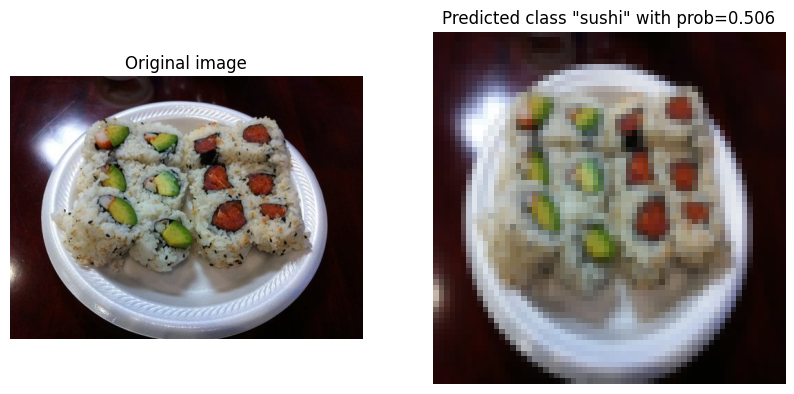

<Figure size 640x480 with 0 Axes>

In [11]:
# Example running of predict.py

# Following line runs in a separate process, so plot is not shown
# !python going_modular/predict.py --image data/pizza_steak_sushi/test/sushi/175783.jpg

# Following line runs the code inside the notebook process, so it shows the plots
%run going_modular/predict.py --image data/pizza_steak_sushi/test/sushi/175783.jpg